In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertions = list(h5_file[calibration_path].keys())
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = '210422_green_tests/green_testing_210422.h5'
file = path_name + test_file_name

ses1_cals = create_list_of_calibrations_in_node(file, 'session001')

ses2_cals = create_list_of_calibrations_in_node(file, 'session002')

cals = []
for cal in ses1_cals:
    ses_cal = 'session001/' + cal
    cals.append(ses_cal)
for cal in ses2_cals:
    ses_cal = 'session002/' + cal
    cals.append(ses_cal)

In [4]:
soil_paths = ['session001/cal002/ins007', 'session001/cal002/ins008', 'session001/cal002/ins009', 'session001/cal002/ins010',
              'session001/cal002/ins011', 'session002/cal001/ins007', 'session002/cal002/ins017', 'session002/cal003/ins020',
              'session002/cal003/ins036']

cap_paths = ['session001/cal002/ins012', 'session001/cal002/ins013', 'session001/cal002/ins014', 'session002/cal001/ins008',
             'session002/cal002/ins018']

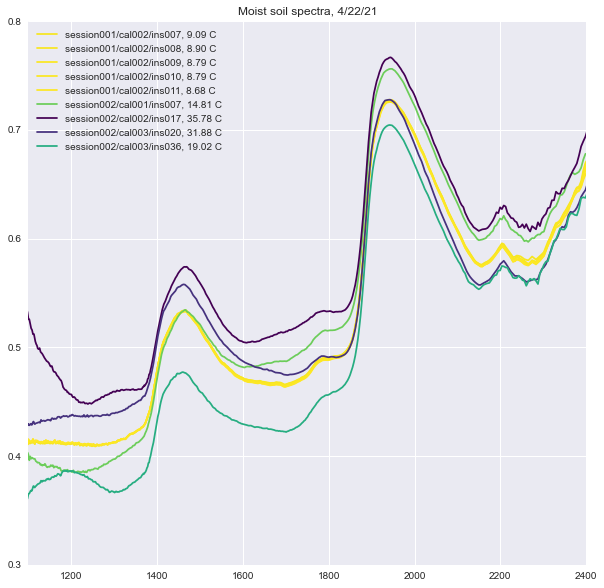

In [44]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.3, 0.8)
ax.set_title("Moist soil spectra, 4/22/21")

for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()
    
    

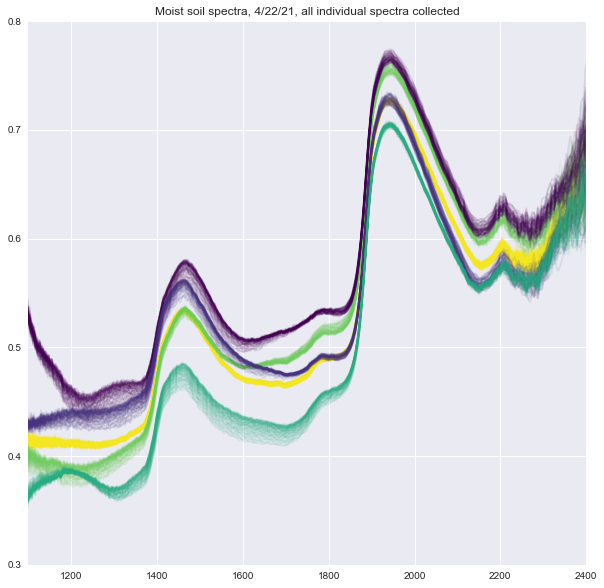

In [55]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.3, 0.8)
ax.set_title("Moist soil spectra, 4/22/21, all individual spectra collected")

for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)

plt.show()
plt.close()

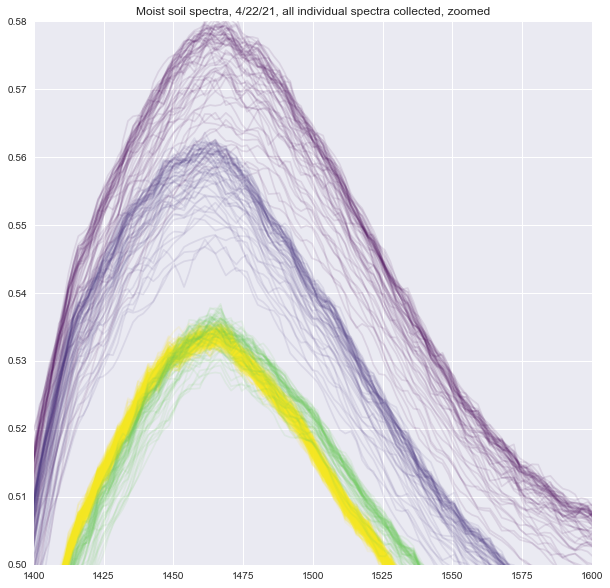

In [72]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1400, 1600)
ax.set_ylim(0.5, 0.58)
ax.set_title("Moist soil spectra, 4/22/21, all individual spectra collected, zoomed")

for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)

plt.show()
plt.close()

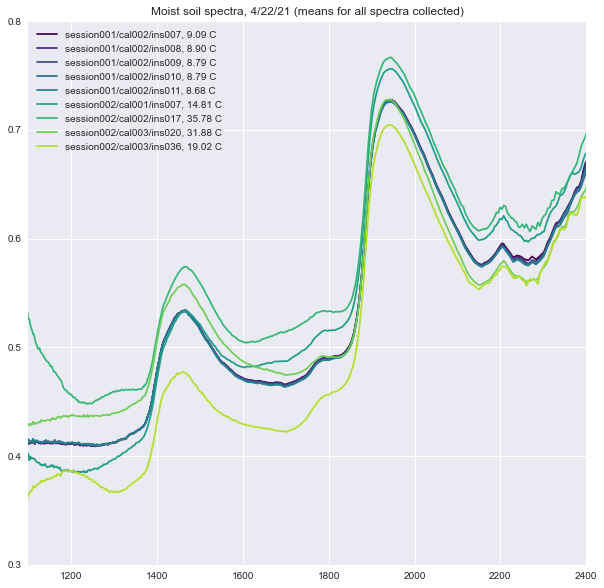

In [73]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.3, 0.8)
ax.set_title("Moist soil spectra, 4/22/21 (means for all spectra collected)")

for insertion in soil_paths:
    index = soil_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(soil_paths))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

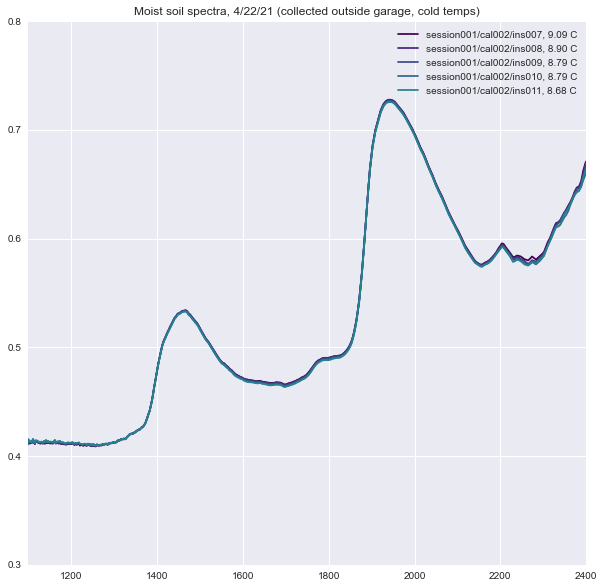

In [16]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.3, 0.8)
ax.set_title("Moist soil spectra, 4/22/21 (collected outside garage, cold temps)")

for insertion in soil_paths[:5]:
    index = soil_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(soil_paths))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

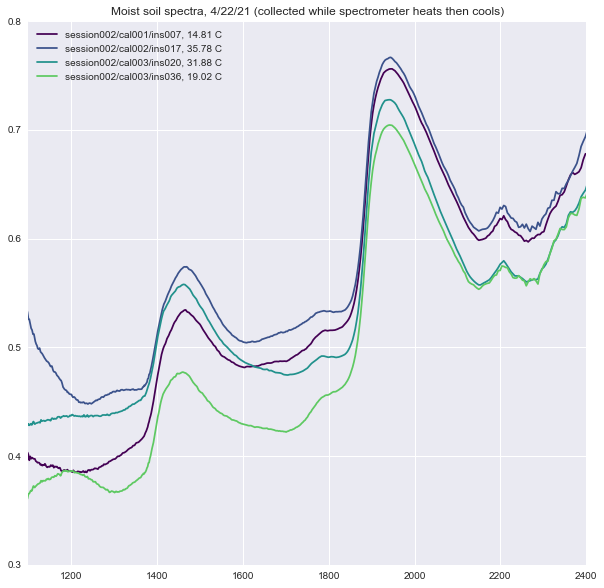

In [23]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.3, 0.8)
ax.set_title("Moist soil spectra, 4/22/21 (collected while spectrometer heats then cools)")

for insertion in soil_paths[5:]:
    index = soil_paths[5:].index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(soil_paths[5:]))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

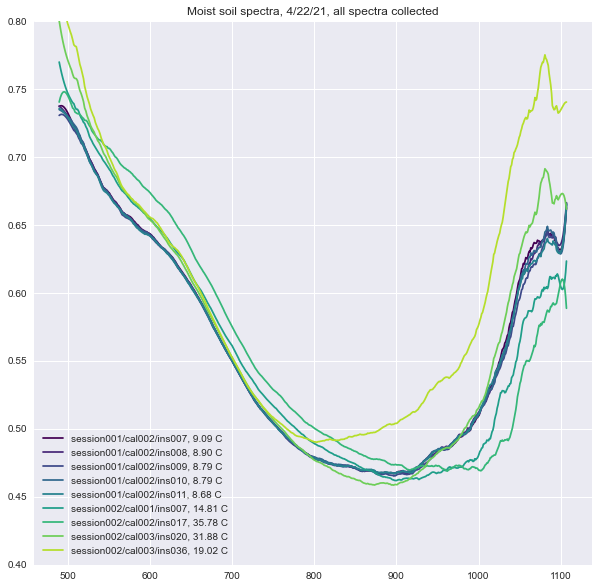

In [31]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(0.4, 0.8)
ax.set_title("Moist soil spectra, 4/22/21, all spectra collected")

for insertion in soil_paths:
    index = index = soil_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(soil_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)

    ax.plot(vis_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

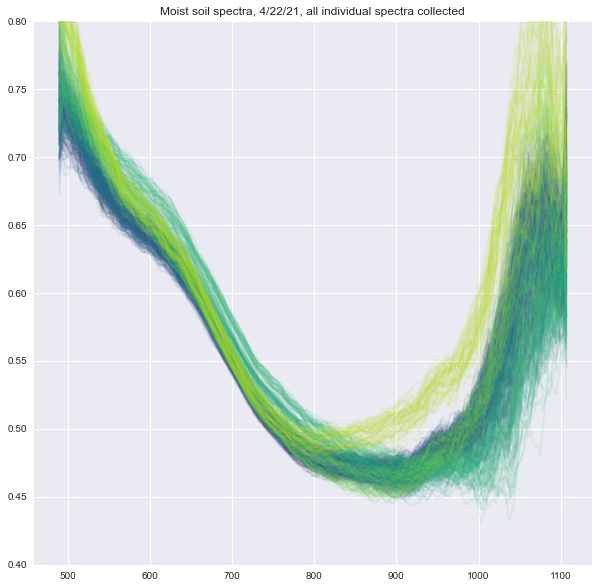

In [57]:
insertion_temps = []
for insertion in soil_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(0.4, 0.8)
ax.set_title("Moist soil spectra, 4/22/21, all individual spectra collected")

for insertion in soil_paths:
    index = index = soil_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(soil_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    for i in range(ins_raw.shape[0]):

        ax.plot(vis_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)

plt.show()
plt.close()

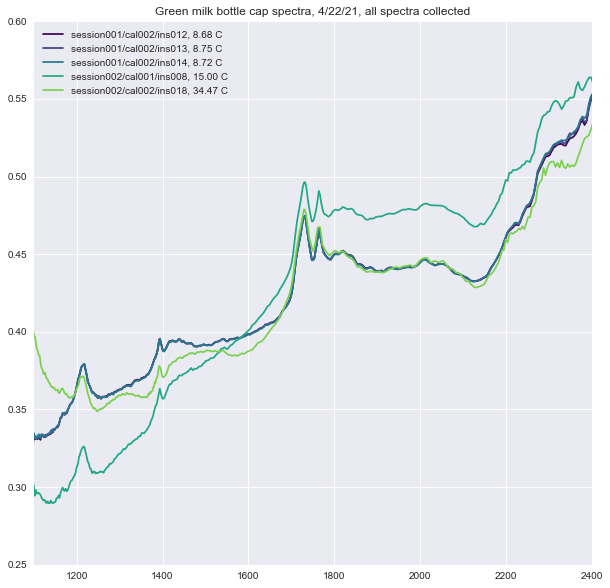

In [43]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.25, 0.6)
ax.set_title("Green milk bottle cap spectra, 4/22/21, all spectra collected")

for insertion in cap_paths:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

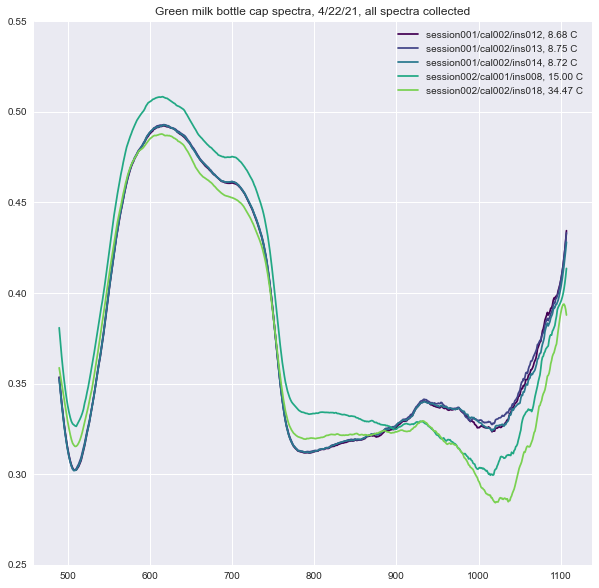

In [45]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(0.25, 0.55)
ax.set_title("Green milk bottle cap spectra, 4/22/21, all spectra collected")

for insertion in cap_paths:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)

    ax.plot(vis_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

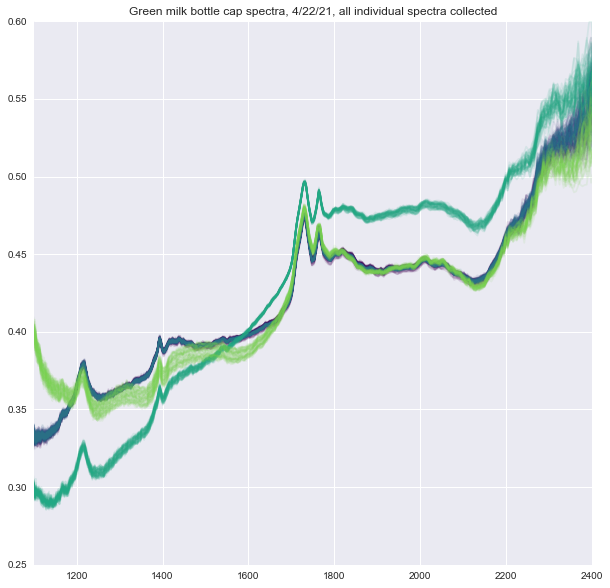

In [51]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

ftir_waves = get_ftir_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.25, 0.6)
ax.set_title("Green milk bottle cap spectra, 4/22/21, all individual spectra collected")

for insertion in cap_paths:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    for i in range(ins_raw.shape[0]): 
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)

plt.show()
plt.close()

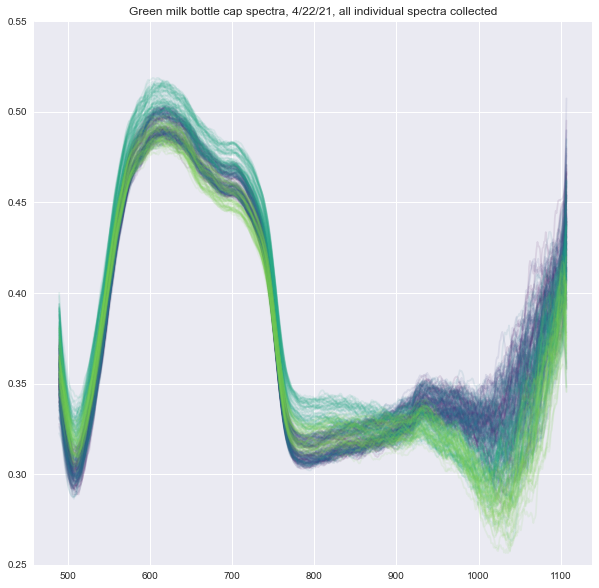

In [52]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(0.25, 0.55)
ax.set_title("Green milk bottle cap spectra, 4/22/21, all individual spectra collected")

for insertion in cap_paths:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    for i in range(ins_raw.shape[0]):

        ax.plot(vis_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)

plt.show()
plt.close()

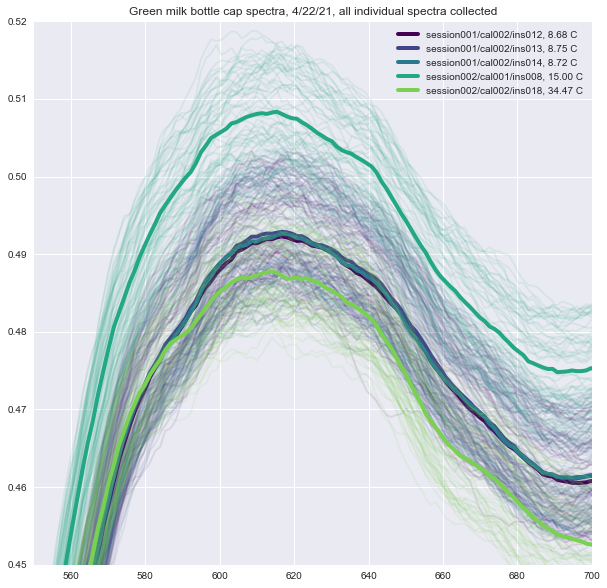

In [61]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(550, 700)
ax.set_ylim(0.45, 0.52)
ax.set_title("Green milk bottle cap spectra, 4/22/21, all individual spectra collected")

for insertion in cap_paths:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ax.plot(vis_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):

        ax.plot(vis_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()

plt.show()
plt.close()

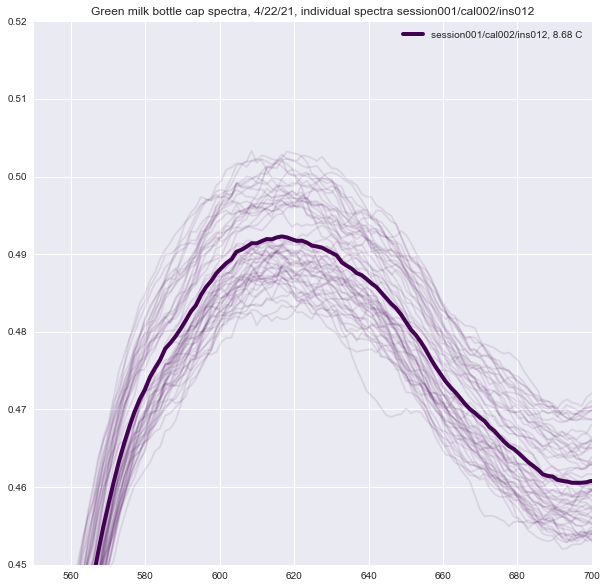

In [69]:
insertion_temps = []
for insertion in cap_paths:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

vis_waves = get_visible_wavelength_vector(file, 'session001/cal002')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(550, 700)
ax.set_ylim(0.45, 0.52)
ax.set_title("Green milk bottle cap spectra, 4/22/21, individual spectra session001/cal002/ins012")

for insertion in cap_paths[:1]:
    index = cap_paths.index(insertion)
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis(index/len(cap_paths))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ax.plot(vis_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):

        ax.plot(vis_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()

plt.show()
plt.close()